In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import silence_tensorflow.auto
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

import keras.backend as K
from keras.callbacks import Callback
from keras.utils import Progbar

from sklearn.model_selection import train_test_split

In [3]:
# S.no           Class_name 
# 00              Aeroplane
# 02              Bicycle
# 03              Bird
# 04              Boat
# 05              Bottle
# 06              Bus
# 07              Car
# 08              Cat
# 09              Chair
# 10              Cow
# 11              Diningtable
# 12              Dog
# 13              Horse
# 14              Motorbike
# 15              Person
# 16              Pottedplant
# 17              Sheep
# 18              Sofa
# 19              Train
# 20              Tvmonitor

In [4]:
image = cv2.imread('pascalvoc/images/000002.jpg')[...,::-1]
image = cv2.resize(image, (448, 448))

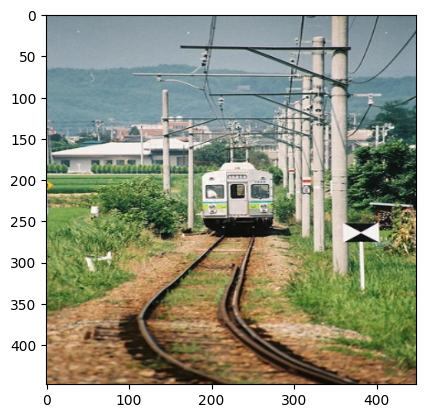

In [5]:
plt.imshow(image)

In [6]:
def draw_rectangle_image_rawdata(x_center, y_center, width, height, image):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    cell_width = image.shape[1] / 19
    cell_height = image.shape[0] / 19
    
    for i in range(1, 19):
        x = i * cell_width
        y = i * cell_height
        ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)
        ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)
        
    rectangle = patches.Rectangle(
        (x_center - width/2, y_center - height/2),
        width,
        height,
        edgecolor='red',
        facecolor='none',
        linewidth=2,
    )
    ax.add_patch(rectangle)
    rectangle.set_zorder(3)

    ax.plot(x_center, y_center, 'r+', linewidth=2)

    plt.show()

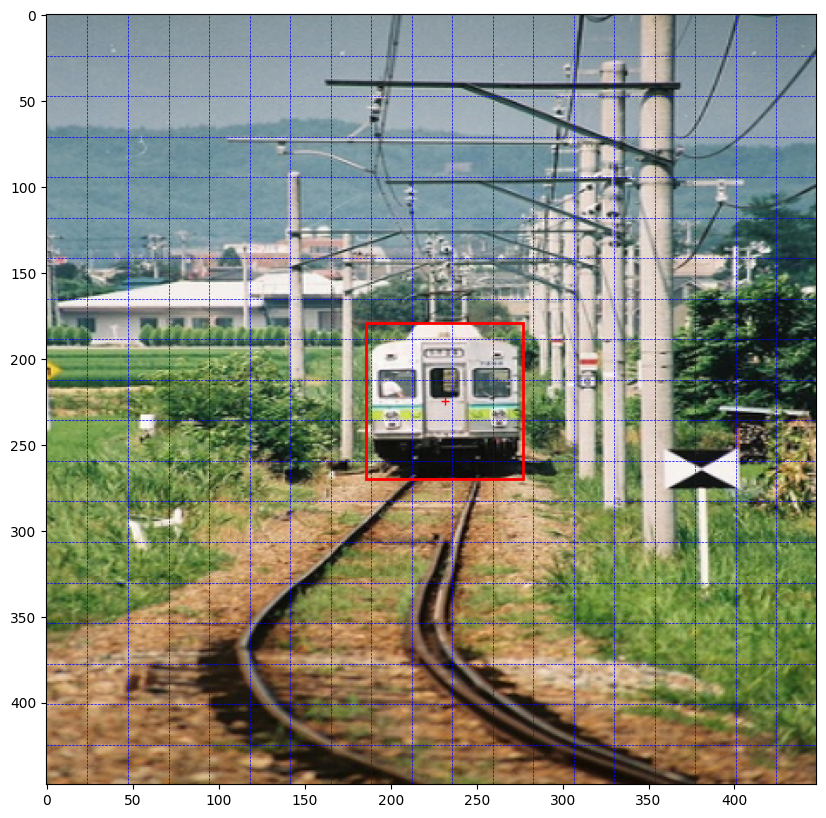

In [7]:
x_center = 0.5164179104477612 * image.shape[1]  # The number has been taken from the label file
y_center = 0.501 * image.shape[0]  # from label file
width = 0.20298507462686569 * image.shape[1]  # from label file
height = 0.202 * image.shape[0]  # from label file

draw_rectangle_image_rawdata(x_center, y_center, width, height, image)

In [8]:
def read(img_file, label_file):
    images_directory = 'pascalvoc/images/'
    labels_directory = 'pascalvoc/labels/'

    image_path = os.path.join(images_directory, img_file)
    label_path = os.path.join(labels_directory, label_file)

    image = cv2.imread(image_path)[...,::-1]
    image = cv2.resize(image, (448, 448))
    image = image/255
    
    with open(label_path, 'r') as file:
        label_content = [[float(value) for i, value in enumerate(line.split())] for line in file.read().splitlines()]

    print(label_content)
    label_matrix = np.zeros([19, 19, 30])
    
    for i in label_content:
        cl = int(i[0]) 
        
        x_center = i[1] 
        y_center = i[2] 
        width = i[3] 
        heigth = i[4] 
        
        loc = [19 * x_center, 19 * y_center]
        loc_i = int(loc[1])
        loc_j = int(loc[0])

        y = loc[1] - loc_i 
        x = loc[0] - loc_j
        
        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cl] = 1 
            label_matrix[loc_i, loc_j, 20:24] = [x, y, width, heigth]
            label_matrix[loc_i, loc_j, 24] = 1

    return image, label_matrix

In [9]:
def draw_rectangle_image_yolo(yolo_matrix, image):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    cell_width = image.shape[1] / 19
    cell_height = image.shape[0] / 19

    for i in range(1, 19):
        x = i * cell_width
        y = i * cell_height
        ax.axvline(x, color='black', linestyle='--', linewidth=0.1)
        ax.axhline(y, color='black', linestyle='--', linewidth=0.1)
    
    colors = ['#00ffff',
              '#f0ffff',
              '#f5f5dc',
              '#000000',
              '#a52a2a',
              '#00008b',
              '#faaf23',
              '#556b2f',
              '#ff8c00',
              '#33FF57',
              '#9932cc',
              '#e9967a',
              '#ff00ff',
              '#ffd700',
              '#00ff00',
              '#ffff00',
              '#ffffff',
              '#ff0000',
              '#008b8b',
              '#a9a9a9']
    
    for line in range(19):
        for column in range(19):
            if np.any(yolo_matrix[line, column] != 0):
                x_center_rel, y_center_rel, width_rel, height_rel = yolo_matrix[line, column, 20:24]
                
                x_center = (column + x_center_rel)/19 *448
                y_center = (line + y_center_rel)/19 * 448
                width = width_rel * 448
                height = height_rel * 448

                cls = np.argmax(yolo_matrix[line, column, :20] == 1)

                rectangle = patches.Rectangle(
                    (x_center - width / 2, y_center - height / 2),
                    width,
                    height,
                    edgecolor=colors[cls],
                    facecolor='none',
                    # facecolor=colors[cls],
                    # alpha=0.1,
                    linewidth=2,
                )
                ax.add_patch(rectangle)
                rectangle.set_zorder(3)

                ax.plot(x_center, y_center, color=colors[cls], marker='+', linewidth=3)

    plt.show()

[[0.0, 0.406, 0.46546546546546547, 0.444, 0.43843843843843844]]


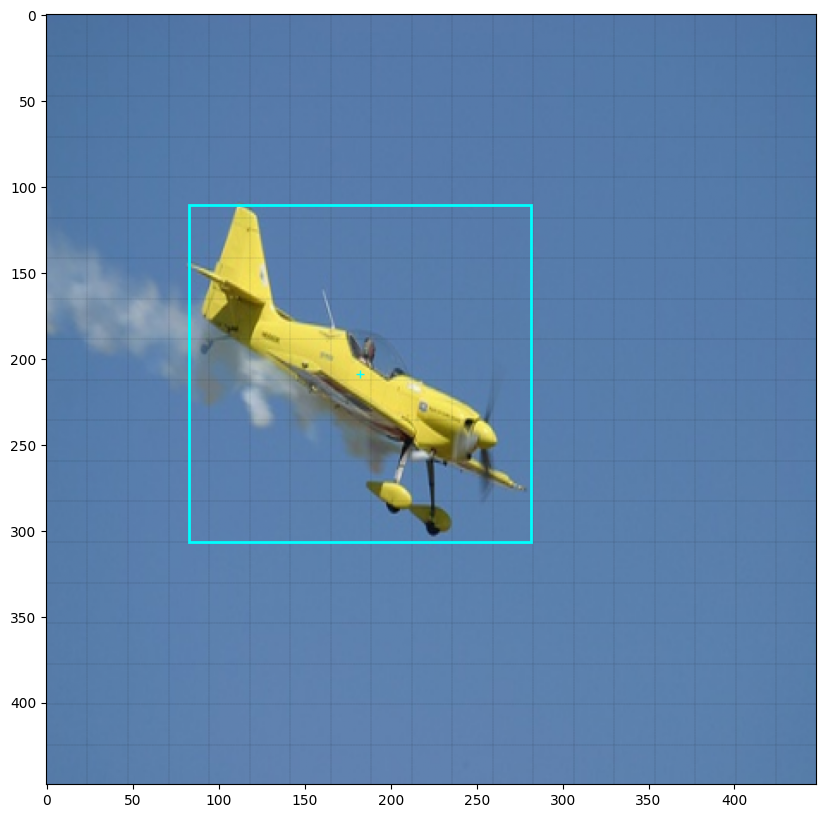

In [10]:
image_matrix, label_matrix = read('000228.jpg','000228.txt')
draw_rectangle_image_yolo(label_matrix,image_matrix)

In [11]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, images_filenames, labels_filenames, batch_size):
        self.images = images_filenames
        self.labels = labels_filenames
        self.batch_size = batch_size
    def __len__(self):
        return (np.ceil(len(self.images) / self.batch_size)).astype(int)
        
    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        set_image = []
        set_label = []

        for i in range(0, len(batch_x)):
            image_filename = batch_x[i]
            label_filename = batch_y[i]
            image_matrix, label_matrix = read(image_filename, label_filename)
            set_image.append(image_matrix)
            set_label.append(label_matrix)
        
        return np.array(set_image), np.array(set_label)

In [12]:
images_directory = 'pascalvoc/images/'
image_files = sorted(os.listdir(images_directory))[:1000]
labels_directory = 'pascalvoc/labels/'
label_files = sorted(os.listdir(labels_directory))[:1000]
batch_size = 100
idx = 2

In [13]:
%%capture
x = My_Custom_Generator(image_files, label_files, batch_size)
set_image, set_label = x[2]

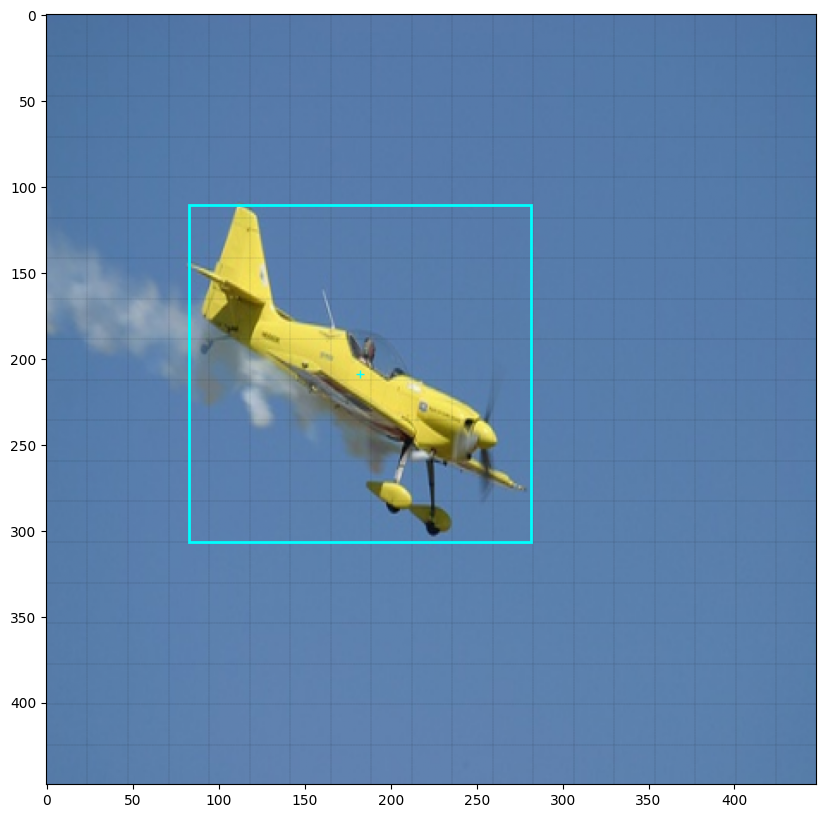

In [14]:
draw_rectangle_image_yolo(set_label[27], set_image[27])

In [15]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        super(Yolo_Reshape, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input):
        S = [self.target_shape[0], self.target_shape[1]]
        C = 20
        B = 2

        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B

        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
        class_probs = K.softmax(class_probs)

        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs)

        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)

        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs

In [16]:
def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max

In [17]:
def iou(pred_mins, pred_maxes, true_mins, true_maxes):

    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    
    iou_scores = intersect_areas / union_areas

    return iou_scores

In [18]:
def yolo_head(feats):
    """
    Convert bounding box features into two separate tensors: xy coordinates and dimensions (weight and height).
    - xy coordinates are converted from grid cell scale to image scale
    - dimensions were and remain at image scale
    Finally, scales the coordinates and dimensions to the original image size (x448).
    
    Parameter:
        - feats: bounding box tensor only in the shape of (batch_size, 7, 7, n_box, [x, y, w, h])
        
    Return:
        - box_xy: tensor of shape (batch_size, 7, 7, n_box, [x, y])
        - box_wh: tensor of shape (batch_size, 7, 7, n_box, [w, h])
    """
    conv_dims = K.shape(feats)[1:3]

    conv_height_index = K.arange(0, stop=conv_dims[0]) 
    conv_width_index = K.arange(0, stop=conv_dims[1])

    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    conv_width_index = K.tile( K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])

    conv_width_index = K.flatten(K.transpose(conv_width_index))
    
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))
    
    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh

In [19]:
def yolo_loss(y_true, y_pred):
    """
    Extracts class labels, confidence score, and bounding box coordinates from both true labels and predictions.
    Computes the Intersection over Union scores and identifies the best IOU for each predicted box.
    Defines confidence loss (confidence_loss), class prediction loss (class_loss), and bounding box loss (box_loss).
    Combines the losses with specified weights (0.5 for no object confidence, 5 for coordinates/dimensions, square root for dimensions).
    Compute the total loss as the sum of individual losses.
    
    Parameters:
    - y_true: tensor of ground truth
    - y_pred: tensor of predictions by the model
    
    Output:
    - loss: scalar representing the loss of the model
    """
    #  Extracts the TRUE class labels from the ground truth tensor
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    # 1 confidence: the 25th channel indicates whether object is present in grid cell
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1 -> Expands dimensions to make it compatible for further operations
    # 1 true bounding box
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    
    
    # Extracts the PREDICTED class probabilities from the model's output tensor
    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    # 2 confidences
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    # 2 bounding boxes
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    # Reshapes the bounding box coordinates to have an additional dimension, preparing it for further calculations.
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    # Scale coordinates to image scale and multiply by 448
    label_xy, label_wh = yolo_head(_label_box)  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    # Expands the dimensions
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # (? * 7 * 7 * 1 * 1 * 2), (? * 7 * 7 * 1 * 1 * 2)
    
    # Scale coordinates to image scale and multiply by 448
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)
    # Expands the dimensions
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # (? * 7 * 7 * 2 * 1 * 2), (? * 7 * 7 * 2 * 1 * 2)
    
    # IOU SCORE between predict and truth
    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    # Reshape iou_scores
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    # Selects the best iou score among the two predicted boxes
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    # Assign 1 to the best bounding box, 0 to the other one
    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    # LOSS CALCULATION
    ## Confidence loss: no object
    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    # True Positive  0.5 * (1 -    1     *       1      ) *         (0 -     0.9  )² = 0 -> because there is actually an object
    # True Negative  0.5 * (1 -   0/1    *       0      ) *         (0 -     0.1  )² = 0.005 (low cost)
    # False Postive  0.5 * (1 -    1     *       0      ) *         (0 -     0.9  )² = 0.405 (medium cost)
    # False Negative 0.5 * (1 -    1     *       1      ) *         (0 -     0.1  )² = 0 -> because there is actually an object    
    
    ## Confidence loss: object
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    # True Pos       1     *      1        *         (1 -   0.9  )² = 0.01 (low cost)
    # True Neg      0/1    *      0        *         (1 -   0.1  )² = 0 -> because there is actually no object
    # False Pos      1     *      0        *         (1 -   0.9  )² = 0 -> because there is actually no object
    # False Neg      1     *      1        *         (1 -   0.1  )² = 0.81 (high cost)

    # Sums up the confidence loss.
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss) # -> scalar

    ## Classes loss
    # class_loss: Loss for predicted class probabilities
    class_loss = response_mask * K.square(label_class - predict_class)
    # True Pos        obj=1    *         (   dog=1    -   0.9)² = 0.01 (low cost) -> There is a dog, and I'm sure it's a dog
    
    # True Neg        obj=0    *         (   cat=0    -   0.1)² = 0 -> There is no object, I can predict anything
    # True Neg        obj=1    *         (   boat=0   -   0.1)² = 0.01 (low cost) -> There is a dog, and I know it's not a boat
    
    # False Pos       obj=0    *         (   cat=0    -   0.9)² = 0 -> There is no object, I can predict anything
    # False Pos       obj=1    *         (   boat=0   -   0.9)² = 0.81 (high cost) -> There is a dog, but I'm sure it's a boat

    # False Neg       obj=1    *         (   dog=1    -   0.1)² = 0.81 (high cost) -> There is a dog, but I'm sure it's not a dog
    # Sums up the class loss
    class_loss = K.sum(class_loss) # -> scalar

    # Reshaping operations
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    label_xy, label_wh = yolo_head(_label_box)        # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    box_mask = K.expand_dims(box_mask)           # ? * 7 * 7 * 2 * 1
    response_mask = K.expand_dims(response_mask) # ? * 7 * 7 * 1 * 1
    
    ## Bounding boxes loss
    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    # True Pos  5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -   0.6/sqrt(0.6))² = 0.05 / 0.02 (low cost)
    # True Neg  5 *  0/1    *      0     *     (  0/sqrt(0)     -   0.1/sqrt(0.1))² = 0 -> I can predict anything
    # False Pos 5 *   1     *      0     *     (  0/sqrt(0)     -   0.5/sqrt(0.5))² = 0 -> I can predict anything    
    # False Neg 5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -     0/sqrt(0)  )² = 1.25 / 2.5 (really high cost) 
    box_loss = K.sum(box_loss) # -> scalar

    # Combines the three components to get the final loss
    loss = confidence_loss + class_loss + box_loss
    
    return loss

In [20]:
lrelu = tf.keras.layers.LeakyReLU(negative_slope=0.1)

def yolo_cnn(input_shape):
    model = Sequential()
    # Conv. layer 1
    model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(2, 2), input_shape =input_shape, padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
    
    # Conv. layer 2
    model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layer 3
    model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # lConv. layer 4
    model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 5
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 6
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 7-14
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv.layer 15
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 16
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 4
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 17-20
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 21
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 22
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

    # Conv. layer 23
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 24
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))

    model.add(Flatten()) # Transform the last output into a single vector
    
    model.add(Dense(4096))
    model.add(Dropout(0.5)) # Dropout rate to prevent overfitting
    model.add(Dense(1470, activation='sigmoid'))
    model.add(Yolo_Reshape(target_shape=(7,7,30)))
    
    
    model.compile(loss=yolo_loss, optimizer='adam')
    
    return model


In [21]:
class CustomLearningRateScheduler(Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

      Argument:
      schedule: a function that takes an epoch index (integer, indexed from 0) and current learning rate
      as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        # checks whether the optimizer has a LR attribute
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call the provided schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the scheduled learning rate back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


# Define a schedule of learning rates at specific epochs
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    # If the epoch is before the first scheduled change or after the last, keep the current learning rate
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    # Iterate through the schedule and return the learning rate if the epoch matches a scheduled change
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
        
    # If the epoch is not in the schedule, keep the current learning rate
    return lr

In [22]:
checkpoint_filepath = 'best_weights.weights.h5'
mcp_save = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [23]:
class ProgressBarLogger(Callback):
    def __init__(self):
        self.epochs = 0
        self.progbar = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.progbar = Progbar(target=self.params['steps'])

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.progbar.update(batch, list(logs.items()))

In [24]:
images_directory = 'pascalvoc/images/'
labels_directory = 'pascalvoc/labels/'

images_list = os.listdir(images_directory)
labels_list = os.listdir(labels_directory)
print('*** Before ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}\n')

images_noextension_set = set([os.path.splitext(image)[0] for image in images_list])
labels_noextension_set = set([os.path.splitext(label)[0] for label in labels_list])

intersection_set = labels_noextension_set.intersection(images_noextension_set)

images_list = sorted([f"{filename}.jpg" for filename in intersection_set])
labels_list = sorted([f"{filename}.txt" for filename in intersection_set])
print('*** After ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}')

*** Before ***
Image list length: 43223
Label list length: 21503

*** After ***
Image list length: 21503
Label list length: 21503


In [25]:
images_list_small = images_list[:21440]
labels_list_small = labels_list[:21440]

X_train_temp, X_test_filenames, Y_train_temp, Y_test_filenames = train_test_split(images_list_small, labels_list_small, test_size=0.2, random_state=456)

X_train_filenames, X_val_filenames, Y_train_filenames, Y_val_filenames = train_test_split(X_train_temp, Y_train_temp, test_size=(1/4), random_state=456)

print(f'Train shape: {len(X_train_filenames)}')
print(f'Validation shape: {len(X_val_filenames)}')
print(f'Test shape: {len(X_test_filenames)}')

Train shape: 12864
Validation shape: 4288
Test shape: 4288


In [26]:
%%capture
batch_size = 1

my_training_batch_generator = My_Custom_Generator(X_train_filenames, Y_train_filenames, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, Y_val_filenames, batch_size)

X_train_gen, Y_train_gen = my_training_batch_generator.__getitem__(0)
print(f'Training set shape: {X_train_gen.shape}')
print(f'Training target shape: {Y_train_gen.shape}')

In [31]:
input_shape = (X_train_gen.shape[1], X_train_gen.shape[2], X_train_gen.shape[3])

model = yolo_cnn(input_shape)

model.summary()

/home/aman/.conda/envs/NLP/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 